In [1]:
from pathlib import Path

import cv2
import yaml
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataloader import build_dataloader
from models import YOLOv3_Model
from utils import *

ROOT = Path.cwd()

EXP_NAME = 'test10'
data_path = ROOT / 'data' / 'coco128.yml'
config_path = ROOT / 'config' / 'yolov3.yml'
save_path = ROOT / 'experiments' / EXP_NAME

with open(config_path) as f:
    item = yaml.load(f, Loader=yaml.FullLoader)

is_cuda = False
batch_size = 1
log_level = item['LOG_LEVEL']
num_epochs = item['NUM_EPOCHS']
input_size = item['INPUT_SIZE']

device = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')
dataloaders, classname_list = build_dataloader(data_path=data_path, 
                                               image_size=(input_size, input_size),
                                               batch_size=batch_size)
num_classes = len(classname_list)
model = YOLOv3_Model(config_path=config_path, num_classes=num_classes, device=device)
model = model.to(device)

ckpt_path = save_path / 'weights' / '2022-07-30_17-50-EP39.pth'
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt, strict=True)
model.eval()

color_list = generate_random_color(num_colors=num_classes)
GT_file = './data/evals/coco128_val.json'
with open(GT_file, 'r') as file:
    GT_data = json.load(file)

imageToinfo = {}
for item in GT_data['images']:
    imageToinfo[item['filename']] = (item['id'], item['height'], item['width'])

[TRAIN] hash: 22207404  version: 2022-07-28_21:26  
[VAL] hash: 7499800  version: 2022-07-30_16:31  


In [6]:
for index, mini_batch in enumerate(dataloaders['val']):
    images = mini_batch[0].to(device)
    targets = mini_batch[1]
    filenames = mini_batch[2]

    with torch.no_grad():
        predictions = model(images)
    
    for idx in range(batch_size):
        filename = filenames[idx]
        pred_yolo = torch.cat(predictions, dim=1)[idx].cpu().numpy()
        pred_yolo = filter_obj_score(prediction=pred_yolo, conf_threshold=0.1)
#         pred_yolo = run_NMS_for_yolo(prediction=pred_yolo, iou_threshold=0.5)
        
#     ######## visualize ########
#     img_h, img_w = imageToinfo[filename][1:]
#     canvas = denormalize(images[idx])
#     canvas = cv2.resize(canvas, dsize=(img_w, img_h))
#     pred_voc = pred_yolo.copy()
#     pred_voc[:, 1:5] = box_transform_xcycwh_to_x1y1x2y2(pred_voc[:, 1:5]/input_size)
#     pred_voc[:, 1:5] = scale_to_original(pred_voc[:, 1:5], scale_w=img_w, scale_h=img_h)    

    if index == 5:
        break

In [53]:
bboxes = pred_yolo[:, 1:5]
scores = pred_yolo[:, 5]

x1 = np.minimum(bboxes[:, 0] - bboxes[:, 2]/2, 0)
y1 = np.minimum(bboxes[:, 1] - bboxes[:, 3]/2, 0)
x2 = bboxes[:, 0] + bboxes[:, 2]/2
y2 = bboxes[:, 1] + bboxes[:, 3]/2
areas = (x2 - x1 + 1) * (y2 - y1 + 1)
order = scores.argsort()[::-1]

pick = []
while len(order) > 0:
    i = order[0]
    pick.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
    inter = w * h
    overlap = inter / (areas[i] + areas[order[1:]])
    idxs = np.where(overlap <= 0.5)[0]
#     order = order[idxs + 1]

KeyboardInterrupt: 

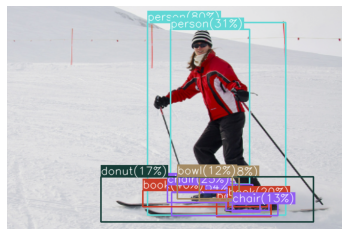

In [37]:
canvas = visualize(canvas, pred_voc, classname_list, color_list, show_class=True, show_score=True)
plt.figure(figsize=(6,6))
plt.imshow(canvas[..., ::-1])
plt.axis('off')
plt.show()

In [5]:
import os
from datetime import datetime
from collections import defaultdict

import cv2
import yaml
import torch

from dataloader import build_dataloader
from models import YOLOv3_Model
from loss_function import YOLOv3_Loss
from utils import *

from pathlib import Path

In [6]:
FILE = Path('__file__').resolve()
ROOT = FILE.parents[0]

EXP_NAME = 'test12'
data_path = ROOT / 'data' / 'coco128.yml'
config_path = ROOT / 'config' / 'yolov3.yml'
save_path = ROOT / 'experiments' / EXP_NAME

time_created = datetime.today().strftime('%Y-%m-%d_%H-%M')
os.makedirs(save_path, exist_ok=True)

with open(data_path) as f:
    data_item = yaml.load(f, Loader=yaml.FullLoader)

with open(config_path) as f:
    config_item = yaml.load(f, Loader=yaml.FullLoader)

is_cuda = config_item['IS_CUDA']
log_level = config_item['LOG_LEVEL']
anchor_iou_threshold = config_item['ANCHOR_IOU_THRESHOLD']
min_conf_threshold = config_item['MIN_SCORE_THRESH']
min_iou_threshold = config_item['MIN_IOU_THRESH']
num_epochs = 100
input_size = config_item['INPUT_SIZE']
batch_size = config_item['BATCH_SIZE']
lr = config_item['LEARNING_RATE']
weight_decay = config_item['WEIGHT_DECAY']

img_log_dir = save_path / 'images'
os.makedirs(img_log_dir, exist_ok=True)

logger = build_logger(log_path=save_path / 'logs', set_level=log_level)
device = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')
dataloaders, classname_list = build_dataloader(data_path=data_path, 
                                                        image_size=(input_size, input_size), 
                                                        batch_size=batch_size)
val_file = data_path.parent / data_item['mAP_FILE']
assert val_file.is_file(), RuntimeError(f'Not exist val file, expected {val_file}')

num_classes = len(classname_list)
model = YOLOv3_Model(config_path=config_path, num_classes=num_classes, device=device)
model = model.to(device)

criterion = YOLOv3_Loss(config_path=config_path, model=model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

evaluator = Evaluator(GT_file=val_file, model_input_size=input_size)
color_list = generate_random_color(num_colors=num_classes)

[TRAIN] hash: 22207404  version: 2022-07-28_21:26  
[VAL] hash: 7499800  version: 2022-07-30_16:31  


In [7]:
best_mAP = 0.01

for epoch in range(num_epochs):
    message = f'[Epoch:{epoch+1:02d}/{num_epochs}]'
    print(message)
    
    ### TRAIN ####
    loss_per_phase = defaultdict(float)
    loss_types = ['total', 'coord', 'obj', 'noobj', 'cls']
    detections = []

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        for index, mini_batch in enumerate(dataloaders[phase]):
            if index == 0:
                canvas = mini_batch[0][0]

            images = mini_batch[0].to(device, non_blocking=True)
            targets = mini_batch[1]
            filenames = mini_batch[2]

            with torch.set_grad_enabled(phase == 'train'):
                predictions = model(images)
            losses = criterion(predictions, targets)

            if phase == 'train':
                optimizer.zero_grad()
                losses[0].backward()
                optimizer.step()

            elif phase == 'val':
                for idx in range(batch_size):
                    filename = filenames[idx]
                    pred_yolo = torch.cat(predictions, dim=1)[idx].cpu().numpy()
                    pred_yolo = filter_obj_score(prediction=pred_yolo, conf_threshold=min_conf_threshold)
                    pred_yolo = run_NMS_for_yolo(prediction=pred_yolo, iou_threshold=min_iou_threshold)
                    detections.append((filename, pred_yolo))
            
            for loss_name, loss_value in zip(loss_types, losses):
                loss_per_phase[f'{phase}_{loss_name}'] += loss_value.item()
                
        for loss_name in loss_per_phase.keys():
            if loss_name.startswith(phase):
                loss_per_phase[loss_name] /= len(dataloaders[phase])

        if phase == 'val':
            filename, pred_yolo = detections[0]
            img_h = evaluator.image_to_info[filename]['height']
            img_w = evaluator.image_to_info[filename]['width']
            canvas = denormalize(canvas)
            canvas = cv2.resize(canvas, dsize=(img_w, img_h))

            pred_voc = pred_yolo.copy()
            pred_voc[:, 1:5] = box_transform_xcycwh_to_x1y1x2y2(pred_voc[:, 1:5]/input_size)
            pred_voc[:, 1:5] = scale_to_original(pred_voc[:, 1:5], scale_w=img_w, scale_h=img_h)
            canvas = visualize(canvas, pred_voc, classname_list, color_list, show_class=True, show_score=True)
            mAP_info, eval_text = evaluator(detections)
    ################

    monitor_text = f' Loss - Train: {loss_per_phase["train_total"]:.2f}, Val: {loss_per_phase["val_total"]:.2f}'
    logger.debug(message + monitor_text)
    logger.info(eval_text)

[Epoch:01/100]
[Epoch:02/100]
[Epoch:03/100]
[Epoch:04/100]
[Epoch:05/100]
[Epoch:06/100]
[Epoch:07/100]
[Epoch:08/100]
[Epoch:09/100]
[Epoch:10/100]
[Epoch:11/100]
[Epoch:12/100]
[Epoch:13/100]
[Epoch:14/100]
[Epoch:15/100]
[Epoch:16/100]
[Epoch:17/100]
[Epoch:18/100]
[Epoch:19/100]
[Epoch:20/100]
[Epoch:21/100]
[Epoch:22/100]
[Epoch:23/100]
[Epoch:24/100]
[Epoch:25/100]
[Epoch:26/100]
[Epoch:27/100]
[Epoch:28/100]
[Epoch:29/100]
[Epoch:30/100]
[Epoch:31/100]
[Epoch:32/100]
[Epoch:33/100]
[Epoch:34/100]
[Epoch:35/100]
[Epoch:36/100]
[Epoch:37/100]
[Epoch:38/100]
[Epoch:39/100]
[Epoch:40/100]
[Epoch:41/100]
[Epoch:42/100]
[Epoch:43/100]
[Epoch:44/100]
[Epoch:45/100]
[Epoch:46/100]
[Epoch:47/100]
[Epoch:48/100]
[Epoch:49/100]
[Epoch:50/100]
[Epoch:51/100]
[Epoch:52/100]
[Epoch:53/100]
[Epoch:54/100]
[Epoch:55/100]
[Epoch:56/100]
[Epoch:57/100]
[Epoch:58/100]
[Epoch:59/100]
[Epoch:60/100]
[Epoch:61/100]
[Epoch:62/100]
[Epoch:63/100]
[Epoch:64/100]
[Epoch:65/100]
[Epoch:66/100]
[Epoch:67/

TypeError: list indices must be integers or slices, not tuple

In [22]:
mAP_info, eval_text = evaluator(detections)

TypeError: list indices must be integers or slices, not tuple

In [29]:
len(detections)

48

In [30]:
for det in detections:
    if len(det[1]) == 0:
        print(det[0])

000000001675.jpg


In [24]:
for det in detections:
    filename, pred_yolo = det
    img_id = evaluator.image_to_info[filename]['image_id']
    img_h = evaluator.image_to_info[filename]['height']
    img_w = evaluator.image_to_info[filename]['width']
    
    pred_voc = pred_yolo.copy()
    pred_voc[:, 1:5] = box_transform_xcycwh_to_x1y1x2y2(pred_voc[:, 1:5]/input_size)
    pred_voc[:, 1:5] = scale_to_original(pred_voc[:, 1:5], scale_w=img_w, scale_h=img_h)

TypeError: list indices must be integers or slices, not tuple

In [25]:
pred_yolo

[]

In [1]:
from pathlib import Path

import cv2
import yaml
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataloader import build_dataloader
from models import YOLOv3_Model
from utils import *

ROOT = Path.cwd()

EXP_NAME = 'test05'
data_path = ROOT / 'data' / 'coco128.yml'
config_path = ROOT / 'config' / 'yolov3.yml'
save_path = ROOT / 'experiments' / EXP_NAME

with open(config_path) as f:
    item = yaml.load(f, Loader=yaml.FullLoader)

is_cuda = False
batch_size = 1
log_level = item['LOG_LEVEL']
num_epochs = item['NUM_EPOCHS']
input_size = item['INPUT_SIZE']

device = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')
dataloaders, classname_list = build_dataloader(data_path=data_path, 
                                               image_size=(input_size, input_size),
                                               batch_size=batch_size)
num_classes = len(classname_list)
model = YOLOv3_Model(config_path=config_path, num_classes=num_classes, device=device)
model = model.to(device)

ckpt_path = save_path / 'weights' / '2022-07-28_22-09-EP48.pth'
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt, strict=True)
model.eval()

color_list = generate_random_color(num_colors=num_classes)

######## calculate mAP ########
GT_file = './data/evals/coco128_train.json'
with open(GT_file, 'r') as file:
    GT_data = json.load(file)

imageToinfo = {}
for item in GT_data['images']:
    imageToinfo[item['filename']] = (item['id'], item['height'], item['width'])

[TRAIN] hash: 22207404  version: 2022-07-28_21:26  
[VAL] hash: 7499800  version: 2022-07-30_16:31  


FileNotFoundError: [Errno 2] No such file or directory: './data/evals/coco128_train.json'

In [142]:
from pathlib import Path

import cv2
import yaml
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataloader import build_dataloader
from models import YOLOv3_Model
from utils import *

In [143]:
ROOT = Path.cwd()

EXP_NAME = 'test'
data_path = ROOT / 'data' / 'coco128.yml'
config_path = ROOT / 'config' / 'yolov3.yml'
save_path = ROOT / 'experiments' / EXP_NAME

with open(config_path) as f:
    item = yaml.load(f, Loader=yaml.FullLoader)

is_cuda = False
batch_size = 1
log_level = item['LOG_LEVEL']
num_epochs = item['NUM_EPOCHS']
input_size = item['INPUT_SIZE']

device = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')
dataloaders, classname_list = build_dataloader(data_path=data_path, 
                                               image_size=(input_size, input_size),
                                               batch_size=batch_size)
num_classes = len(classname_list)
model = YOLOv3_Model(config_path=config_path, num_classes=num_classes, device=device)
model = model.to(device)

ckpt_path = save_path / 'weights' / '2022-07-27_20-52-50.pth'
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt, strict=True)
model.eval()

color_list = generate_random_color(num_colors=num_classes)

######## calculate mAP ########
GT_file = './data/evals/coco128_train.json'
with open(GT_file, 'r') as file:
    GT_data = json.load(file)

imageToinfo = {}
for item in GT_data['images']:
    imageToinfo[item['filename']] = (item['id'], item['height'], item['width'])

groundtruths = GT_data['annotations']
classes = list(map(int, GT_data['categories'].keys()))

[TRAIN] hash: 22207404  version: 2022-07-27_20:51  
[VAL] hash: 961646  version: 2022-07-27_20:51  


In [144]:
detections = []
conf_threshold = 0.01
iou_threshold = 0.5

for index, mini_batch in enumerate(dataloaders['train']):
    images = mini_batch[0].to(device)
    targets = mini_batch[1]
    filenames = mini_batch[2]

    with torch.no_grad():
        predictions = model(images)
    
    for idx in range(batch_size):
        filename = filenames[idx]
        pred_yolo = torch.cat(predictions, dim=1)[idx].cpu().numpy()
        pred_yolo = filter_obj_score(prediction=pred_yolo, conf_threshold=conf_threshold)
        pred_yolo_ = pred_yolo.copy()
        pred_yolo = run_NMS_for_yolo(prediction=pred_yolo, iou_threshold=iou_threshold)
        
        ####### calculate mAP ########        
        img_id = imageToinfo[filename][0]
        img_h, img_w = imageToinfo[filename][1:]
        pred_voc = pred_yolo.copy()
        pred_voc[:, 1:5] = box_transform_xcycwh_to_x1y1x2y2(pred_voc[:, 1:5])
        pred_voc[:, 1:5] = scale_to_original(pred_voc[:, 1:5], scale_w=img_w, scale_h=img_h)
        
        for item in pred_voc:
            pred_dict = {}
            pred_dict['image_id'] = img_id
            pred_dict['bbox'] = list(item[1:5])
            pred_dict['area'] = round((item[3]-item[1])*(item[4]-item[2]),2)
            pred_dict['class_id'] = int(item[0])
            pred_dict['confidence'] = float(item[5])
            detections.append(pred_dict)

In [398]:
from collections import Counter

def is_intersect(boxA, boxB):
    if boxA[0] > boxB[2]:
        return False  # boxA is right of boxB
    if boxA[1] > boxB[3]:
        return False  # boxA is below boxB
    if boxA[2] < boxB[0]:
        return False  # boxA is left boxB
    if boxA[3] < boxB[1]:
        return False  # boxA is above boxB
    return True

def get_intersection(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    return (xB-xA+1) * (yB-yA+1)

def get_union(boxA, boxB):
    area_A = (boxA[2]-boxA[0]+1) * (boxA[3]-boxA[1]+1)
    area_B = (boxB[2]-boxB[0]+1) * (boxB[3]-boxB[1]+1)
    return area_A + area_B

def get_IoU(boxA, boxB):
    if is_intersect(boxA, boxB) is False:
        return 0
    intersect = get_intersection(boxA, boxB)
    union = get_union(boxA, boxB)
    result = intersect / (union-intersect)
    return result

def calculate_AveragePrecision(rec, prec):
    mrec = [0] + [e for e in rec] + [1]
    mpre = [0] + [e for e in prec] + [0]

    for i in range(len(mpre)-1, 0, -1):
        mpre[i-1] = max(mpre[i-1], mpre[i])

    ii = []
    for i in range(len(mrec)-1):
        if mrec[1:][i] != mrec[0:-1][i]:
            ii.append(i+1)

    ap = 0
    for i in ii:
        ap += np.sum((mrec[i] - mrec[i-1]) * mpre[i])
    return ap

In [399]:
maxDets = 100
iouThrs = np.linspace(.5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)

In [400]:
image_ids = set(map(lambda x:x['image_id'], detections))
detections_ = [[item for item in detections if item['image_id']==x][:maxDets] for x in image_ids]
detections_2 = []
for item in detections_:
    detections_2.extend(item)

In [401]:
result = []

for c in classes:
    gts = [g for g in groundtruths if g['class_id'] == c]
    dects = [d for d in detections_2 if d['class_id'] == c]

    npos = len(gts)
    dects = sorted(dects, key=lambda x:x['confidence'], reverse=True)
    TP = np.zeros(shape=(len(iouThrs), len(dects)))
    FP = np.zeros(shape=(len(iouThrs), len(dects)))

    det = Counter(cc['image_id'] for cc in gts)
    for key, val in det.items():
        det[key] = np.zeros(shape=(len(iouThrs), val))

    for d in range(len(dects)):
        gt = [gt for gt in gts if gt['image_id'] == dects[d]['image_id']]
        iou_max = 0
        
        for j in range(len(gt)):
            iou = get_IoU(dects[d]['bbox'], gt[j]['bbox'])
            if iou > iou_max:
                iou_max = iou
                jmax = j
        
        for idx in range(len(iouThrs)):
            if iou_max >= iouThrs[idx]:
                if det[dects[d]['image_id']][idx, jmax] == 0:
                    det[dects[d]['image_id']][idx, jmax] = 1
                    TP[idx, d] = 1
                else:
                    FP[idx, d] = 1
            else:
                FP[idx, d] = 1

    acc_FP = np.cumsum(FP, axis=1)
    acc_TP = np.cumsum(TP, axis=1)
    rec = acc_TP / (npos + 1e-8)
    prec = np.divide(acc_TP, (acc_FP + acc_TP))
    
    APs = []
    ap_05_095 = 0
    for idx in range(len(iouThrs)):
        ap = calculate_AveragePrecision(rec[idx], prec[idx])
        ap_05_095 += (iouThrs[idx] * ap)
        APs.append(ap)
    ap_05_095 /= sum(iouThrs)
    
    res = {
        'class' : c,
        'precision_05' : list(prec[0].round(4)),
        'recall_05' : list(rec[0].round(4)),
        'AP_05' : APs[0],
        'AP_075' : APs[5],
        'AP_05_095' : ap_05_095,
        'total positives' : npos,
        'total TP' : np.sum(TP),
        'total FP' : np.sum(FP)
    }
    result.append(res)

AP_05_per_class = {}
mAP_05 = 0
mAP_075 = 0
mAP_05_095 = 0

for res in result:
    AP_05_per_class[res['class']] = res['AP_05']
    mAP_05 += res['AP_05']
    mAP_075 += res['AP_075']
    mAP_05_095 += res['AP_05_095']
    
mAP_05 = mAP_05 / len(result)
mAP_075 = mAP_075 / len(result)
mAP_05_095 = mAP_05_095 / len(result)

In [402]:
mAP_05_095

0.12043916420570056

In [403]:
mAP_05

0.2971858857172339

In [404]:
mAP_075

0.09820467750788069

In [405]:
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.130
#  Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.305
#  Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.100

In [408]:
from collections import defaultdict
maxDets = 100
iouThrs = np.linspace(.5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
areaRng = [[0 ** 2, 32 ** 2], [32 ** 2, 96 ** 2], [96 ** 2, 1e5 ** 2]]

In [411]:
image_ids = set(map(lambda x:x['image_id'], detections))
detections_ = [[item for item in detections if item['image_id']==x][:maxDets] for x in image_ids]

detections_2 = []
for item in detections_:
    detections_2.extend(item)
    
detections_3 = defaultdict(list)
for item in detections_2:
    if areaRng[0][0] <= item['area'] <= areaRng[0][1]:
        detections_3['s'].append(item)
    elif areaRng[1][0] <= item['area'] <= areaRng[1][1]:
        detections_3['m'].append(item)
    elif areaRng[2][0] <= item['area'] <= areaRng[2][1]:
        detections_3['l'].append(item)

groundtruths_ = defaultdict(list)
for item in groundtruths:
    if areaRng[0][0] <= item['area'] <= areaRng[0][1]:
        groundtruths_['s'].append(item)
    elif areaRng[1][0] <= item['area'] <= areaRng[1][1]:
        groundtruths_['m'].append(item)
    elif areaRng[2][0] <= item['area'] <= areaRng[2][1]:
        groundtruths_['l'].append(item)

In [417]:
res_area = {}
for area_range in ['s', 'm', 'l']:
    result = []
    for c in classes:
        gts = [g for g in groundtruths_[area_range] if g['class_id'] == c]
        dects = [d for d in detections_3[area_range] if d['class_id'] == c]

        npos = len(gts)
        dects = sorted(dects, key=lambda x:x['confidence'], reverse=True)
        TP = np.zeros(shape=(len(iouThrs), len(dects)))
        FP = np.zeros(shape=(len(iouThrs), len(dects)))

        det = Counter(cc['image_id'] for cc in gts)
        for key, val in det.items():
            det[key] = np.zeros(shape=(len(iouThrs), val))

        for d in range(len(dects)):
            gt = [gt for gt in gts if gt['image_id'] == dects[d]['image_id']]
            iou_max = 0

            for j in range(len(gt)):
                iou = get_IoU(dects[d]['bbox'], gt[j]['bbox'])
                if iou > iou_max:
                    iou_max = iou
                    jmax = j

        for idx in range(len(iouThrs)):
            if iou_max >= iouThrs[idx]:
                if det[dects[d]['image_id']][idx, jmax] == 0:
                    det[dects[d]['image_id']][idx, jmax] = 1
                    TP[idx, d] = 1
                else:
                    FP[idx, d] = 1
            else:
                FP[idx, d] = 1

        acc_FP = np.cumsum(FP, axis=1)
        acc_TP = np.cumsum(TP, axis=1)
        rec = acc_TP / (npos + 1e-8)
        prec = np.divide(acc_TP, (acc_FP + acc_TP))

        APs = []
        ap_05_095 = 0
        for idx in range(len(iouThrs)):
            ap = calculate_AveragePrecision(rec[idx], prec[idx])
            ap_05_095 += (iouThrs[idx] * ap)
            APs.append(ap)
        ap_05_095 /= sum(iouThrs)

        res = {
            'class' : c,
            'precision_05' : list(prec[0].round(4)),
            'recall_05' : list(rec[0].round(4)),
            'AP_05' : APs[0],
            'AP_075' : APs[5],
            'AP_05_095' : ap_05_095,
            'total positives' : npos,
            'total TP' : np.sum(TP),
            'total FP' : np.sum(FP)
        }
        result.append(res)

    for res in result:
        AP_05_per_class[res['class']] = res['AP_05']
        mAP_05 += res['AP_05']
        mAP_075 += res['AP_075']
        mAP_05_095 += res['AP_05_095']

    mAP_05 = mAP_05 / len(result)
    mAP_075 = mAP_075 / len(result)
    mAP_05_095 = mAP_05_095 / len(result)
    
    res_area[area_range] = {'mAP_05':mAP_05, 
                            'mAP_075':mAP_075, 
                            'mAP_05_095': mAP_05_095}

C:\Users\pjh56\AppData\Local\Temp\ipykernel_1376\2376475451.py:41: RuntimeWarning: invalid value encountered in divide
  prec = np.divide(acc_TP, (acc_FP + acc_TP))


IndexError: index 991 is out of bounds for axis 1 with size 0

In [397]:
res_area

{'s': 0.06578677583277766, 'm': 0.1704742823803007, 'l': 0.3660309436986467}

In [ ]:
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.041
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.097
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.219

In [305]:
result = []
map_iou_threshold = 0.5
max_dets = 100

In [233]:
image_ids = set(map(lambda x:x['image_id'], detections))
detections_ = [[item for item in detections if item['image_id']==x][:max_dets] for x in image_ids]
detections_2 = []
for item in detections_:
    detections_2.extend(item)

In [235]:
for c in classes:
    gts = [g for g in groundtruths if g['class_id'] == c]
    dects = [d for d in detections_2 if d['class_id'] == c]

    npos = len(gts)
    dects = sorted(dects, key=lambda x:x['confidence'], reverse=True)
    TP = np.zeros(len(dects))
    FP = np.zeros(len(dects))

    det = Counter(cc['image_id'] for cc in gts)
    for key, val in det.items():
        det[key] = np.zeros(val)

    for d in range(len(dects)):
        gt = [gt for gt in gts if gt['image_id'] == dects[d]['image_id']]
        iou_max = 0
        for j in range(len(gt)):
            iou = get_IoU(dects[d]['bbox'], gt[j]['bbox'])
            if iou > iou_max:
                iou_max = iou
                jmax = j

        if iou_max >= map_iou_threshold:
            if det[dects[d]['image_id']][jmax] == 0:
                det[dects[d]['image_id']][jmax] = 1
                TP[d] = 1
            else:
                FP[d] = 1
        else:
            FP[d] = 1

    acc_FP = np.cumsum(FP)
    acc_TP = np.cumsum(TP)
    rec = acc_TP / (npos + 1e-8)
    prec = np.divide(acc_TP, (acc_FP + acc_TP))
    ap = calculate_AveragePrecision(rec, prec)
    r = {
        'class' : c,
        'precision' : list(prec.round(4)),
        'recall' : list(rec.round(4)),
        'AP' : ap,
        'total positives' : npos,
        'total TP' : np.sum(TP),
        'total FP' : np.sum(FP)
    }
    
    result.append(r)

In [236]:
ap_per_class = {}
ap = 0
for r in result:
    ap_per_class[r['class']] = r['AP']
    ap += r['AP']
mAP = ap / len(result)

In [237]:
mAP

0.2971858857172339

In [154]:
result = []
map_iou_threshold = 0.75
max_dets = 100

image_ids = set(map(lambda x:x['image_id'], detections))
detections_ = [[item for item in detections if item['image_id']==x][:max_dets] for x in image_ids]
detections_2 = []
for item in detections_:
    detections_2.extend(item)

In [155]:
for c in classes:
    gts = [g for g in groundtruths if g['class_id'] == c]
    dects = [d for d in detections_2 if d['class_id'] == c]

    npos = len(gts)
    dects = sorted(dects, key=lambda x:x['confidence'], reverse=True)
    TP = np.zeros(len(dects))
    FP = np.zeros(len(dects))

    det = Counter(cc['image_id'] for cc in gts)
    for key, val in det.items():
        det[key] = np.zeros(val)

    for d in range(len(dects)):
        gt = [gt for gt in gts if gt['image_id'] == dects[d]['image_id']]
        iou_max = 0
        for j in range(len(gt)):
            iou = get_IoU(dects[d]['bbox'], gt[j]['bbox'])
            if iou > iou_max:
                iou_max = iou
                jmax = j

        if iou_max >= map_iou_threshold:
            if det[dects[d]['image_id']][jmax] == 0:
                det[dects[d]['image_id']][jmax] = 1
                TP[d] = 1
            else:
                FP[d] = 1
        else:
            FP[d] = 1

    acc_FP = np.cumsum(FP)
    acc_TP = np.cumsum(TP)
    rec = acc_TP / (npos + 1e-8)
    prec = np.divide(acc_TP, (acc_FP + acc_TP))
    ap, _, _, _ = calculate_AveragePrecision(rec, prec)
    r = {
        'class' : c,
        'precision' : list(prec.round(4)),
        'recall' : list(rec.round(4)),
        'AP' : ap,
        'total positives' : npos,
        'total TP' : np.sum(TP),
        'total FP' : np.sum(FP)
    }
    
    result.append(r)

In [156]:
ap_per_class = {}
ap = 0
for r in result:
    ap_per_class[r['class']] = r['AP']
    ap += r['AP']
mAP = ap / len(result)

In [157]:
mAP

0.09820467750788069

In [ ]:
## Benchmarking mAP from COCO API

In [45]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def xcycwh_to_x1y1wh(bboxes):
    x1 = bboxes[:, 0] - bboxes[:, 2]/2
    y1 = bboxes[:, 1] - bboxes[:, 3]/2
    w = bboxes[:, 2]
    h = bboxes[:, 3]
    return np.stack((x1, y1, w, h), axis=1)

In [46]:
annFile = './data/coco128_eval_train.json'
cocoGt=COCO(annFile)

imageToinfo = {}
for _, value in cocoGt.imgs.items():
    imageToinfo[value['file_name']] = (value['id'], value['height'], value['width'])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [47]:
COCO_anno = []
conf_threshold = 0.01
iou_threshold = 0.5

for index, mini_batch in enumerate(dataloaders['train']):
    images = mini_batch[0].to(device)
    targets = mini_batch[1]
    filenames = mini_batch[2]
    
    with torch.no_grad():
        predictions = model(images)
    
    for idx in range(batch_size):
        filename = filenames[idx]
        img_h, img_w = imageToinfo[filename][1:]
        
        prediction = torch.cat(predictions, dim=1)[idx]
        prediction = prediction.cpu().numpy()
        prediction = filter_obj_score(prediction=prediction, conf_threshold=conf_threshold)
        prediction = run_NMS_for_yolo(prediction=prediction, iou_threshold=iou_threshold)
        bbox_x1y1wh = xcycwh_to_x1y1wh(prediction[:,1:5]*input_size)
        bbox_x1y1wh = np.clip(bbox_x1y1wh, a_min=0., a_max=input_size)

        img_id = np.array([imageToinfo[filename][0], ] * len(bbox_x1y1wh))[:, np.newaxis]
        origin_bbox_x1y1wh = scale_to_original(bbox_x1y1wh, scale_w=img_w/input_size, scale_h=img_h/input_size)
        score = prediction[:, -1][:, np.newaxis]
        cls_id = prediction[:, 0][:, np.newaxis]
        COCO_anno.append(np.concatenate((img_id, origin_bbox_x1y1wh, score, cls_id), axis=1))

In [48]:
cocoDt = cocoGt.loadRes(np.concatenate(COCO_anno, axis=0))
cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Loading and preparing results...
Converting ndarray to lists...
(18119, 7)
0/18119
DONE (t=0.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.16s).
Accumulating evaluation results...
DONE (t=0.45s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.186
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.192
 Average Recall   

In [1]:
from pathlib import Path

import cv2
import yaml
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataloader import build_dataloader
from models import YOLOv3_Model
from utils import *

In [3]:
ROOT = Path.cwd()

EXP_NAME = 'test'
data_path = ROOT / 'data' / 'coco128.yml'
config_path = ROOT / 'config' / 'yolov3.yml'
save_path = ROOT / 'experiments' / EXP_NAME

with open(config_path) as f:
    item = yaml.load(f, Loader=yaml.FullLoader)

is_cuda = False
batch_size = 1
log_level = item['LOG_LEVEL']
num_epochs = item['NUM_EPOCHS']
input_size = item['INPUT_SIZE']

device = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')
dataloaders, classname_list = build_dataloader(data_path=data_path, 
                                               image_size=(input_size, input_size),
                                               batch_size=batch_size)
num_classes = len(classname_list)
model = YOLOv3_Model(config_path=config_path, num_classes=num_classes, device=device)
model = model.to(device)

ckpt_path = save_path / 'weights' / '2022-07-27_20-52-50.pth'
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt, strict=True)
model.eval()

color_list = generate_random_color(num_colors=num_classes)

######## calculate mAP ########
GT_file = './data/evals/coco128_train.json'
with open(GT_file, 'r') as file:
    GT_data = json.load(file)

imageToinfo = {}
for item in GT_data['images']:
    imageToinfo[item['filename']] = (item['id'], item['height'], item['width'])

groundtruths = GT_data['annotations']
detections = []
classes = list(map(int, GT_data['categories'].keys()))

[TRAIN] hash: 22207404  version: 2022-07-27_20:51  
[VAL] hash: 961646  version: 2022-07-27_20:51  


In [43]:
conf_threshold = 0.1
iou_threshold = 0.5

for index, mini_batch in enumerate(dataloaders['train']):
    images = mini_batch[0].to(device)
    targets = mini_batch[1]
    filenames = mini_batch[2]

    with torch.no_grad():
        predictions = model(images)
    
    for idx in range(batch_size):
        filename = filenames[idx]
        pred_yolo = torch.cat(predictions, dim=1)[idx].cpu().numpy()
        pred_yolo = filter_obj_score(prediction=pred_yolo, conf_threshold=conf_threshold)
        pred_yolo_ = pred_yolo.copy()
        pred_yolo = run_NMS_for_yolo(prediction=pred_yolo, iou_threshold=iou_threshold)
        
        ######## visualize ########
        img_h, img_w = imageToinfo[filename][1:]
        canvas = denormalize(images[idx])
        canvas = cv2.resize(canvas, dsize=(img_w, img_h))
        pred_voc = pred_yolo.copy()
        pred_voc[:, 1:5] = box_transform_xcycwh_to_x1y1x2y2(pred_voc[:, 1:5])
        pred_voc[:, 1:5] = scale_to_original(pred_voc[:, 1:5], scale_w=img_w, scale_h=img_h)    

    if index == 0:
        break

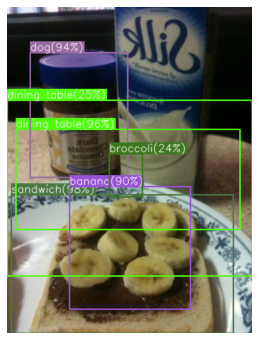

In [44]:
canvas = visualize(canvas, pred_voc, classname_list, color_list, show_class=True, show_score=True)

plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.axis('off')
plt.show()

In [1]:
from pathlib import Path

import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataloader import build_dataloader
from models import YOLOv3_Model
from utils import generate_random_color, visualize, filter_obj_score, run_NMS_for_yolo, denormalize

In [3]:
ROOT = Path.cwd()

EXP_NAME = 'test01'
data_path = ROOT / 'data' / 'coco128.yml'
config_path = ROOT / 'config' / 'yolov3.yml'
save_path = ROOT / 'experiments' / EXP_NAME

with open(config_path) as f:
    item = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
log_level = item['LOG_LEVEL']
is_cuda = False
num_epochs = item['NUM_EPOCHS']
input_size = item['INPUT_SIZE']
batch_size = 1

device = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')
dataloaders, classname_list = build_dataloader(data_path=data_path, 
                                               image_size=(input_size, input_size),
                                               batch_size=batch_size)
num_classes = len(classname_list)
model = YOLOv3_Model(config_path=config_path, num_classes=num_classes, device=device)
model = model.to(device)

color_list = generate_random_color(num_colors=num_classes)

[TRAIN] hash: 22207404  version: 2022-06-30_22:28  
[VAL] hash: 7499800  version: 2022-07-04_21:13  


In [5]:
ckpt_path = save_path / 'weights' / '2022-07-07_20-04-50.pth'
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt, strict=True)
model.eval()

YOLOv3_Model(
  (backbone): Darknet53_backbone(
    (conv1): ConvLayer(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lrelu): LeakyReLU(negative_slope=0.1)
    )
    (res_block1): Sequential(
      (conv): ConvLayer(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (lrelu): LeakyReLU(negative_slope=0.1)
      )
      (res0): ResBlock(
        (conv1): ConvLayer(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.1)
        )
        (conv2): ConvLayer(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [53]:
phase = 'train'
conf_threshold = 0.5
iou_threshold = 0.4

for index, mini_batch in enumerate(dataloaders[phase]):
    images = mini_batch[0].to(device)
    targets = mini_batch[1]
    filenames = mini_batch[2]
    
    with torch.no_grad():
        predictions = model(images)
    
    canvas = denormalize(images[0])
    prediction = torch.cat(predictions, dim=1)[0]
    prediction = prediction.cpu().numpy()
    prediction = filter_obj_score(prediction=prediction, conf_threshold=conf_threshold)
    prediction = run_NMS_for_yolo(prediction=prediction, iou_threshold=iou_threshold)
    
    if index == 0:
        break

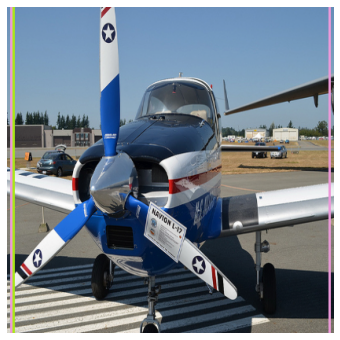

In [54]:
canvas = visualize(canvas, prediction, classname_list, color_list, show_class=True, show_score=True)

plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.axis('off')
plt.show()

In [83]:
def denormalize(input_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    tensor = input_tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    tensor.clamp_(min=0, max=1.)
    tensor *= 255.
    image = tensor.permute(1,2,0).numpy().astype(np.uint8)
    return image

def filter_conf_score(prediction, conf_threshold=0.01):
    valid_score_index = (prediction[..., 4] > conf_threshold)
    bboxes = prediction[:, :4][valid_score_index]
    conf_scores = prediction[:, 4][valid_score_index]
    class_probs = np.argmax(prediction[:, 5:][valid_score_index], axis=1)
    return np.concatenate([bboxes, conf_scores[:, np.newaxis], class_probs[:, np.newaxis]], axis=-1)

def run_NMS_yolo_format(bboxes, iou_threshold=0.1):
    if len(bboxes) == 0:
        return []
    if bboxes.dtype.kind == "i":
        bboxes = bboxes.astype("float")
    pick = []
    x1 = bboxes[:, 0] - bboxes[:, 2]/2
    y1 = bboxes[:, 1] - bboxes[:, 3]/2
    x2 = bboxes[:, 0] + bboxes[:, 2]/2
    y2 = bboxes[:, 1] + bboxes[:, 3]/2
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > iou_threshold)[0])))
    return pick

In [102]:
phase = 'val'
conf_threshold = 0.5
for index, mini_batch in enumerate(dataloaders['train']):
    images = mini_batch[0].to(device)
    targets = mini_batch[1]
    filenames = mini_batch[2]
    
    with torch.no_grad():
        predictions = model(images)
   
    canvas_image = denormalize(images[0])
    prediction = torch.cat(predictions, dim=1)[0]
    prediction = prediction.cpu().numpy()
    prediction = filter_conf_score(prediction, conf_threshold=conf_threshold)
    
    if index == 0:
        break

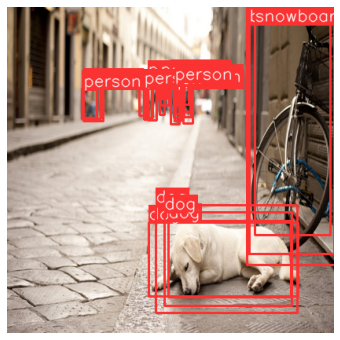

In [103]:
canvas = visualize(canvas_image, prediction[:,:4], prediction[:,5], classname_list)

plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.axis('off')
plt.show()

In [119]:
def denormalize(input_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    tensor = input_tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    tensor.clamp_(min=0, max=1.)
    tensor *= 255.
    image = tensor.permute(1,2,0).numpy().astype(np.uint8)
    return image

def filter_conf_score(prediction, conf_threshold=0.01):
    valid_score_index = (prediction[..., 4] > conf_threshold)
    bboxes = prediction[:, :4][valid_score_index]
    conf_scores = prediction[:, 4][valid_score_index]
    class_probs = np.argmax(prediction[:, 5:][valid_score_index], axis=1)
    return np.concatenate([bboxes, conf_scores[:, np.newaxis], class_probs[:, np.newaxis]], axis=-1)

def run_NMS_yolo_format(bboxes, iou_threshold=0.1):
    if len(bboxes) == 0:
        return []
    if bboxes.dtype.kind == "i":
        bboxes = bboxes.astype("float")
    pick = []
    x1 = bboxes[:, 0] - bboxes[:, 2]/2
    y1 = bboxes[:, 1] - bboxes[:, 3]/2
    x2 = bboxes[:, 0] + bboxes[:, 2]/2
    y2 = bboxes[:, 1] + bboxes[:, 3]/2
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > iou_threshold)[0])))
    return pick

def cxcywh_to_x1y1x2y2(bboxes, input_size):
    xy_min = bboxes[:, 0:2] - bboxes[:, 2:4] / 2
    xy_max = bboxes[:, 0:2] + bboxes[:, 2:4] / 2
    xy_min = xy_min.clip(min=0.)
    xy_max = xy_max.clip(max=input_size)
    return np.concatenate((xy_min, xy_max), axis=1).astype(int)

In [120]:
phase = 'val'
conf_threshold = 0.8
iou_threshold = 0.4

for index, mini_batch in enumerate(dataloaders["train"]):
    images = mini_batch[0].to(device)
    targets = mini_batch[1]
    filenames = mini_batch[2]
    
    with torch.no_grad():
        predictions = model(images)
        
    if phase == 'val':
        canvas_image = denormalize(images[0])
        prediction = torch.cat(predictions, dim=1)[0]
        prediction = prediction.cpu().numpy()
        
        pred_res = filter_conf_score(prediction, conf_threshold=conf_threshold)
        valid_index = run_NMS_yolo_format(bboxes=pred_res[:, :4], iou_threshold=iou_threshold)
        pred_res = pred_res[valid_index]
        
    if index == 0:
        break

In [123]:
pred_res[:,:4]

array([[375.6864624 , 389.98358154,  26.37264824, 475.08203125],
       [343.54598999, 390.0592041 ,  29.67083931, 417.99578857],
       [ 16.53494453, 404.89187622, 317.46508789, 378.96646118],
       [401.04684448, 400.53598022, 295.54498291, 382.1991272 ],
       [207.91131592, 402.05981445, 306.59588623, 300.99389648],
       [264.42459106, 237.19659424, 324.0635376 , 437.43823242],
       [ 52.74630737, 183.06071472, 292.76083374, 354.44784546],
       [370.27770996,  49.84379578, 474.03161621, 321.41976929]])

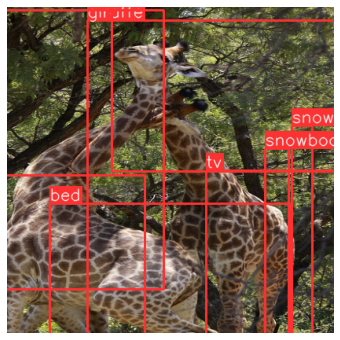

In [121]:
canvas = visualize(canvas_image, pred_res[:,:4], pred_res[:,5], classname_list)

plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.axis('off')
plt.show()